### Bifurcation diagram for the autaptic neuron

Bifurcation diagram when only the tau parameter,the time delay to autaptic input, is varied. 

In [1]:

#imports for AQUA
import sys
sys.path.append("..\\") # parent directory
from AQUA_class import AQUA
from plotting_functions import *


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style = "white")

100%|██████████| 200/200 [10:55<00:00,  3.28s/it]


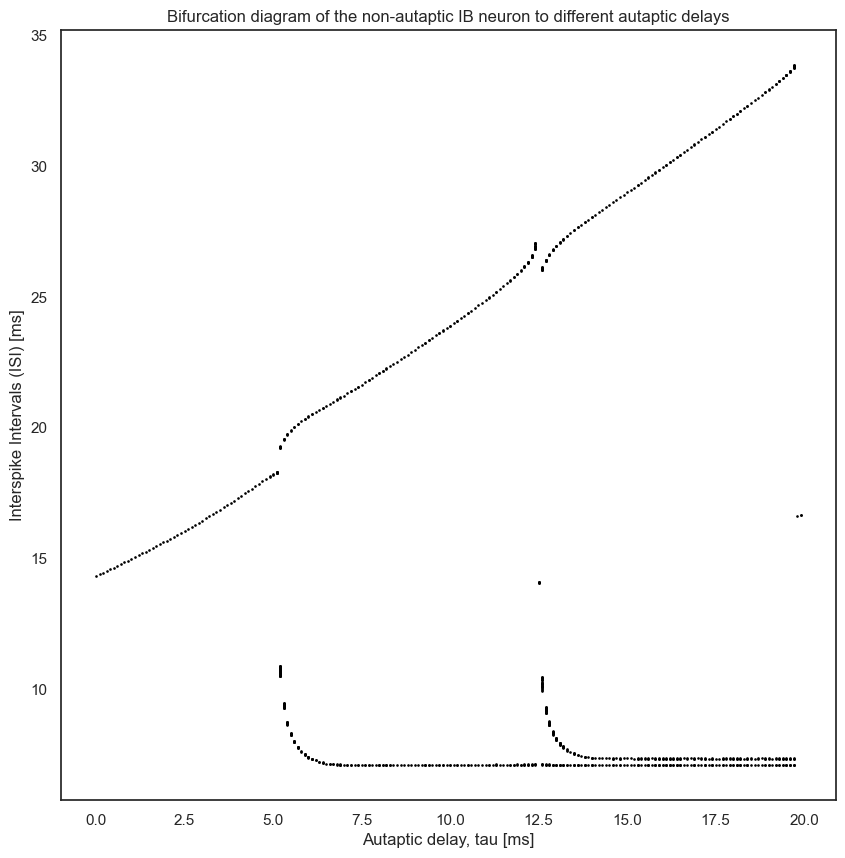

In [2]:
# Bifurcation diagram with autapse
# Different neurons will have different bifurcation diagrams. 
# Neurons are probably also defined by their early behaviour, not just their steady state.

# running the code below with a current step of 0.1 would take ~75 mins

# simulation parameters
T = 2500      # ms
dt = 0.01     # ms
N_iter = int(T/dt)


# Will use the IB neuron of the izhikevich model
name = 'FS'
a = 0.1
b = 0.2
c = -65
d = 2

#autaptic params
e = 0.1
f = -7
dtau = 0.1
tau_vals = np.arange(0, 20, dtau)     # ms

# Injected current values, is fixed
I_height = 10
I_inj = I_height*np.ones(N_iter)

#Initial values to re-initialise neuron
x_start = np.array([c, 0, 0])
t_start = np.array([0])

# dataframe to store variables for plotting
data_array = np.zeros((1, 3))


#define fig and ax
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# loop through e values.
for tau in tqdm(tau_vals):

    neuron = AQUA(a, b, c, d, e, f, tau)
    neuron.Initialise(x_start, t_start)

    X, T, spike_times = neuron.update_RK2(dt, N_iter, I_inj)
    
    #Only get the steady state ISI (last 50% of spikes)
    ISI = np.ediff1d(spike_times[-int(0.5*len(spike_times)):])
    isi_vals, isi_counts = np.unique(np.round(ISI, decimals = 6), return_counts = True)
    ax.scatter(tau*np.ones(len(isi_vals)), isi_vals, c = 'black', s = 0.8, marker = "o")

    for j in range(len(isi_vals)):
        df_row = np.array([tau, isi_vals[j], isi_counts[j]])
        data_array = np.vstack((data_array, df_row))

cols = ['tau', 'ISI_values', 'ISI_counts']
df = pd.DataFrame(data = data_array, columns = cols)

plt.title("Bifurcation diagram of the non-autaptic IB neuron to different autaptic delays")
plt.ylabel("Interspike Intervals (ISI) [ms]")
plt.xlabel("Autaptic delay, tau [ms]")
plt.savefig(f"autaptic_bifurcation_tau_{name}_HD.png")

In [3]:

print(df)

      tau  ISI_values  ISI_counts
0     0.0        0.00         0.0
1     0.0       14.32        86.0
2     0.1       14.38        85.0
3     0.2       14.45        85.0
4     0.3       14.51        85.0
..    ...         ...         ...
921  19.7       33.85         4.0
922  19.7       33.86         1.0
923  19.8       16.60        74.0
924  19.9       16.64        38.0
925  19.9       16.65        39.0

[926 rows x 3 columns]


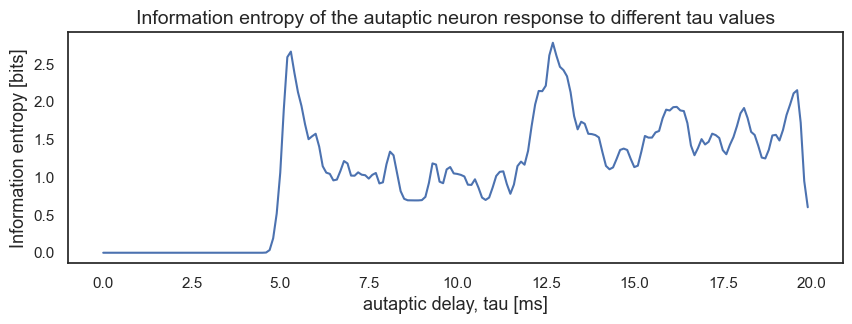

In [4]:
# See the information contained in the ISI distributions for fixed injected currents
H_isi = np.zeros(len(tau_vals))

for n, tau in enumerate(tau_vals):
    counts = df[df['tau'] == tau]['ISI_counts'].to_numpy()
    probs = counts/np.sum(counts)
    H_isi[n] = entropy(probs)

H_isi = gaussian_filter(H_isi, sigma = 1.0)

fig2, ax2 = plt.subplots(figsize = (10, 3))
plt.plot(tau_vals, H_isi, c = 'b')
plt.title("Information entropy of the autaptic neuron response to different tau values", fontsize = 14)
plt.ylabel("Information entropy [bits]", fontsize = 13)
plt.xlabel("autaptic delay, tau [ms]", fontsize = 13)
plt.savefig(f"autaptic_information_tau_{name}.png")